# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
import matplotlib.pyplot as plt
from getData import getData
import pandas as pd
import os

cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [14]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.6, 'CO2':201*1e-6/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [15]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.63},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.63},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [17]:
esM.add(fn.Conversion(esM=esM, name='Electrolyzer', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [18]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [19]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [20]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [22]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [23]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [24]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [25]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [27]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [28]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [29]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

# 8 Temporal Aggregation

In [30]:
esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(1.5251 sec)



 C:\Users\s.patil\Anaconda3\envs\europeanmodel\lib\site-packages\tsam\timeseriesaggregation.py:982: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


### Optimization

In [31]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8874 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.4447 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.7482 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5919 sec)

Declaring shared potential constraint...
		(0.0035 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(1.2291 sec)

Declaring objective function...
		(0.4563 sec)

Either solver not selected or specified solver not available.gurobi is set as

for SourceSinkModel ...    (1.5166sec)
for ConversionModel ...    (1.3688sec)


 c:\users\s.patil\documents\code\fine\FINE\storage.py:1087: UserWarning:Charge and discharge at the same time for component Li-ion batteries
 c:\users\s.patil\documents\code\fine\FINE\storage.py:1087: UserWarning:Charge and discharge at the same time for component Salt caverns (hydrogen)
 c:\users\s.patil\documents\code\fine\FINE\storage.py:1087: UserWarning:Charge and discharge at the same time for component Salt caverns (biogas)
 c:\users\s.patil\documents\code\fine\FINE\storage.py:1087: UserWarning:Charge and discharge at the same time for component Pumped hydro storage


for StorageModel ...       (3.7550sec)
for TransmissionModel ...  (3.7442sec)
		(10.3861 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

In [32]:
# Import the geopandas package for plotting the locations
import geopandas as gpd

 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\

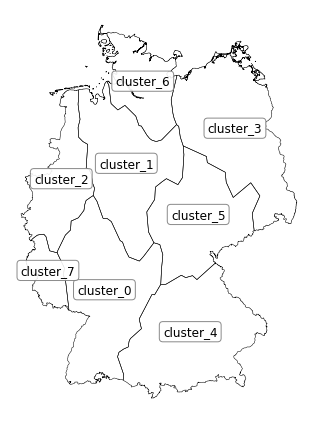

In [33]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [34]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.264223   
                             commodCosts [1e9 Euro/a]             0.264223   
                             operation   [GW$_{biogas,LHV}$*h/a]   4884.88   
                                         [GW$_{biogas,LHV}$*h]     4884.88   
Electricity demand           operation   [GW$_{el}$*h/a]            133963   
                                         [GW$_{el}$*h]              133963   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.144316   
                             capacity    [GW$_{el}$]              0.693828   
                             operation   [GW$_{el}$*h/a]           3167.33   
                                         [GW$_{el}$*h]             3167.33   
                             opexCap     [1e9 Euro/a]             0.144316   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    15855.2   
                                         [GW$_{H_{2},LHV}$*h]      15855.2   
PV                           TAC         [1e9 Euro/a]              3.09316   
                             capacity    [GW$_{el}$]               41.8611   
                             capexCap    [1e9 Euro/a]              2.54897   
                             invest      [1e9 Euro]                27.2097   
                             operation   [GW$_{el}$*h/a]           38289.5   
                                         [GW$_{el}$*h]             38289.5   
                             opexCap     [1e9 Euro/a]             0.544194   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                                         [GW$_{el}$*h]                 NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (onshore)               TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                     0   
                             capexCap    [1e9 Euro/a]                    0   
                             invest      [1e9 Euro]                      0   
                             operation   [GW$_{el}$*h/a]                 0   
                                         [GW$_{el}$*h]                   0   
                             opexCap     [1e9 Euro/a]                    0   

                                                                  cluster_1  \
Component                    Property    Unit                                 
Biogas purchase              TAC         [1e9 Euro/a]              0.253751   
                             commodCosts [1e9 Euro/a]              0.253751   
                             operation   [GW$_{biogas,LHV}$*h/a]    4691.28   
                                         [GW$_{biogas,LHV}$*h]      4691.28   
Electricity demand           operation   [GW$_{el}$*h/a]              66116   
                                         [GW$_{el}$*h]                66116   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.0077909   
                             capacity    [GW$_{el}$]              0.0374563   
                             operation   [GW$_{el}$*h/a]            170.988   
                                         [GW$_{el}$*h]              170.988   
                             opexCap     [1e9 Euro/a]             0.0077909   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]     11007.1   
                                         [GW$_{H_{2},LHV}$*h]       11007.1   
PV                           TAC         [1e9 Euro/a]               1.9

Plot installed capacities

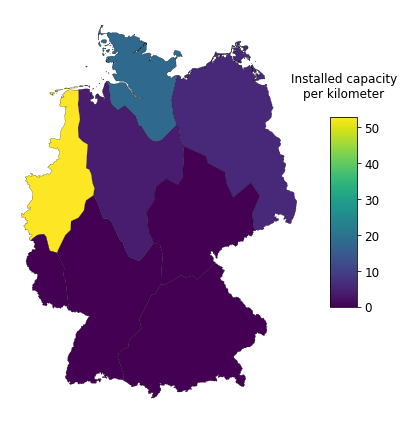

In [35]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (offshore)', locFilePath, 'index', perArea=False)

In [ ]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (onshore)', locFilePath, 'index', perArea=False)

In [ ]:
fig, ax = fn.plotLocationalColorMap(esM, 'PV', locFilePath, 'index', perArea=False)

Plot operation time series (either one or two dimensional)

In [ ]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [ ]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotLocationalColorMap(esM, 'Electrolyzer', locFilePath, 'index', perArea=False)

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

### Storage

Show optimization summary

In [ ]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [ ]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

In [ ]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc['Pipelines (hydrogen)']

Check that the shared capacity of the pipelines are not exceeded

In [ ]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

Plot installed transmission capacities

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='loc1', loc1='loc2',
                              fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='loc1', loc1='loc2',
                              fig=fig, ax=ax)

# Postprocessing: Determine robust pipeline design

In [ ]:
# Import module expansion "robustPipelineSizing"
from FINE.expansionModules import robustPipelineSizing

In [ ]:
# 1. Option to get the injection and withdrawal rates for the pipeline sizing (in kg/s)
rates = robustPipelineSizing.getInjectionWithdrawalRates(componentName='Pipelines (hydrogen)',esM=esM) # in GWh
# Convert GWh to kg/s: GWh * (kWh/GWh) * (kg/kWh) * (1/ timestepLengthInSeconds) with timestepLengthInSeconds
# being 3600 seconds for the present example
rates = rates * (10 ** 6) * (1/33.32) * (1/3600) 
rates.head()

In [ ]:
# 2. Option to get the injection and withdrawal rates for the pipeline sizing (in kg/s)
op = esM.componentModelingDict[esM.componentNames['Pipelines (hydrogen)']].\
    getOptimalValues('operationVariablesOptimum')['values'].loc['Pipelines (hydrogen)']
rates = robustPipelineSizing.getInjectionWithdrawalRates(operationVariablesOptimumData=op) # in GWh
# Convert GWh to kg/s: GWh * (kWh/GWh) * (kg/kWh) * (1/ timestepLengthInSeconds) with timestepLengthInSeconds
# being 3600 seconds for the present example
rates = rates * (10 ** 6) * (1/33.32) * (1/3600) 
rates.head()

In [ ]:
# Determine unique withdrawal and injection scenarios to save computation time
rates = rates.drop_duplicates()
rates.head()

In [ ]:
# Get the lengths of the pipeline (in m)
lengths = robustPipelineSizing.getNetworkLengthsFromESM('Pipelines (hydrogen)', esM)
lengths = lengths * 1e3
lengths.head()

In [ ]:
# Specify minimum and maximum pressure levels for all injection and withdrawal nodes (in bar)
p_min_nodes = {'cluster_5': 60, 'cluster_3': 50, 'cluster_7': 50, 'cluster_1': 60, 'cluster_6': 50,
               'cluster_4': 50, 'cluster_0': 50, 'cluster_2': 50}

p_max_nodes = {'cluster_5': 100, 'cluster_3': 100, 'cluster_7': 100, 'cluster_1': 90, 'cluster_6': 100,
               'cluster_4': 100, 'cluster_0': 100, 'cluster_2': 100}

In [ ]:
# Specify the investment cost of the available diameter classes in €/m

# For single pipes
dic_diameter_costs = {0.1063: 37.51, 0.1307: 38.45, 0.1593: 39.64, 0.2065: 42.12,
                      0.2588: 45.26, 0.3063: 48.69, 0.3356: 51.07, 0.3844: 55.24,
                      0.432: 59.86, 0.4796: 64.98, 0.527: 70.56, 0.578: 76.61,
                      0.625: 82.99, 0.671: 89.95, 0.722: 97.38, 0.7686: 105.28,
                      0.814: 113.63, 0.864: 122.28, 0.915: 131.56, 0.96: 141.3,
                      1.011: 151.5, 1.058: 162.17, 1.104: 173.08, 1.155: 184.67,
                      1.249: 209.24, 1.342: 235.4, 1.444: 263.66, 1.536: 293.78}

# For parallel pipes
dic_candidateMergedDiam_costs={1.342: 235.4, 1.444: 263.66, 1.536: 293.78}

In [ ]:
# Choose if a robust pipeline desin should be determined or the design should be optimized based on the
# given injection and withdrawal rates only
robust = True

### Determine design for simple network structure

In [ ]:
# Compute with 7 threads and simple network structure

dic_arc_optimalDiameters, dic_scen_PressLevels, dic_scen_MaxViolPress, dic_timeStep_PressLevels, \
    dic_timeStep_MaxViolPress, _ = robustPipelineSizing.determineDiscretePipelineDesign(
        robust=robust, injectionWithdrawalRates=rates,
        distances=lengths, dic_node_minPress=p_min_nodes, dic_node_maxPress=p_max_nodes, 
        dic_diameter_costs=dic_diameter_costs, dic_candidateMergedDiam_costs=dic_candidateMergedDiam_costs,
        threads=7)

In [ ]:
# Compute with 2 threads and simple network structure

dic_arc_optimalDiameters, dic_scen_PressLevels, dic_scen_MaxViolPress, dic_timeStep_PressLevels, \
    dic_timeStep_MaxViolPress, _ = robustPipelineSizing.determineDiscretePipelineDesign(
        robust=robust, injectionWithdrawalRates=rates,
        distances=lengths, dic_node_minPress=p_min_nodes, dic_node_maxPress=p_max_nodes, 
        dic_diameter_costs=dic_diameter_costs, dic_candidateMergedDiam_costs=dic_candidateMergedDiam_costs,
        threads=2)

print("Finished Discrete Pipeline Optimization")

### Determine design for more complex network structure

In [ ]:
# Redfine minimum and maximum pressure levels to reduce robust scenario computation time
p_min_nodes = {'cluster_5': 50, 'cluster_3': 50, 'cluster_7': 50, 'cluster_1': 50, 'cluster_6': 50,
               'cluster_4': 50, 'cluster_0': 50, 'cluster_2': 50}

p_max_nodes = {'cluster_5': 100, 'cluster_3': 100, 'cluster_7': 100, 'cluster_1': 100, 'cluster_6': 100,
               'cluster_4': 100, 'cluster_0': 100, 'cluster_2': 100}

In [ ]:
# Get more complex network structure
regColumn1 = 'loc1'
regColumn2 = 'loc2'

dic_node_minPress=p_min_nodes
dic_node_maxPress=p_max_nodes

maxPipeLength= 35 * 1e3
minPipeLength= 1 * 1e3

distances_new, dic_node_minPress_new, dic_node_maxPress_new, gdfNodes, gdfEdges = \
    robustPipelineSizing.getRefinedShapeFile(transFilePath, regColumn1, regColumn2, dic_node_minPress,
                                             dic_node_maxPress, minPipeLength, maxPipeLength)

fig, ax = fn.plotLocations(locFilePath, indexColumn='index') 

gdfEdges.plot(ax=ax, color='grey')
gdfNodes.plot(ax=ax, color='red', markersize=2)
ax.axis('off')

plt.show()

In [ ]:
# Determine optimal pipeline design with seven threads
dic_arc_optimalDiameters, dic_scen_PressLevels, dic_scen_MaxViolPress, dic_timeStep_PressLevels, \
           dic_timeStep_MaxViolPress, gdfEdges = robustPipelineSizing.determineDiscretePipelineDesign(
        robust=robust, injectionWithdrawalRates=rates,
        distances=distances_new, dic_node_minPress=dic_node_minPress_new, dic_node_maxPress=dic_node_maxPress_new,
        dic_diameter_costs=dic_diameter_costs, dic_candidateMergedDiam_costs=dic_candidateMergedDiam_costs,
        gdfEdges=gdfEdges, regColumn1='nodeIn', regColumn2='nodeOut', threads=7, solver='gurobi')

### Plot scenario output

In [ ]:
# Get regions shapefile as geopandas GeoDataFrame
gdf_regions = gpd.read_file(locFilePath)

In [ ]:
# Visualize pipeline diameters
fig, ax =robustPipelineSizing.plotOptimizedNetwork(gdfEdges, gdf_regions=gdf_regions, figsize=(5,5),
    line_scaling=0.8)

In [ ]:
# Get a minimum and maximum pressure scenario
dic_timeStep_PressLevels = pd.DataFrame.from_dict(dic_scen_PressLevels)

scen_min = dic_timeStep_PressLevels.mean().min()
scen_min = dic_timeStep_PressLevels.loc[:,dic_timeStep_PressLevels.mean() == scen_min].iloc[:,0]
scen_max = dic_timeStep_PressLevels.mean().max()
scen_max = dic_timeStep_PressLevels.loc[:,dic_timeStep_PressLevels.mean() == scen_max].iloc[:,0]

In [ ]:
fig, ax =robustPipelineSizing.plotOptimizedNetwork(gdfEdges, gdf_regions=gdf_regions, figsize=(5,5),
    line_scaling=0.9, pressureLevels=scen_min)

In [ ]:
fig, ax =robustPipelineSizing.plotOptimizedNetwork(gdfEdges, gdf_regions=gdf_regions, figsize=(5,5),
    line_scaling=0.9, pressureLevels=scen_max)